# 1D Convolution NN



### Using the raw brachial waveforms and the derivatives --> 2 channels

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

from scripts.NN_helpers import *
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scripts.helpers import *

Load Data

In [2]:
#radial waveforms
RWF_PATH = "../Data/radial_BP_waveforms_HEMODB.csv"
#brachial waveforms
BWF_PATH = "../Data/brachial_BP_waveforms_HEMODB.csv"
#features brSBP, brDBP, HR, cfPWV
U1_PATH = "../Data/u1.csv"
#labels
EES_PATH = "../Data/true_ees.csv"

In [3]:
rd_waveform = pd.read_csv(RWF_PATH, sep=';').set_index("ID")
rd_waveform = rd_waveform.loc[:, (rd_waveform != 0).any(axis=0)] #drop all-0 columns

br_waveform = pd.read_csv(BWF_PATH, sep=';').set_index("ID")
br_waveform = br_waveform.loc[:, (br_waveform != 0).any(axis=0)] #drop all-0 columns

u1_data = pd.read_csv(U1_PATH).set_index("ID")
ees = pd.read_csv(EES_PATH).set_index("ID")
ees = inverse(ees) # the ees value in the csv file is its inverse

### The derivatives of the waveforms

In [4]:
derivatives = derivative(br_waveform)

In [5]:
derivatives.shape

(4018, 80)

In [6]:
raw_waveforms = np.array(br_waveform)
waveforms_2 = np.c_[raw_waveforms,derivatives] # adding the second channel
waveforms_2 = waveforms_2.reshape(4018,2,80)

Splitting data to :

*   Train set 80%
*   Test set 20%




In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(waveforms_2, ees, test_size = 0.20)

In [9]:
X_train.shape

(3214, 2, 80)

## Training and Results

In [10]:
torch.cuda.is_available()

True

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
NUM_EPOCHS = 300
BATCH_SIZE = 32

In [15]:
model = ConvModel2Channels().to(device)
criterion = nn.MSELoss()
dataset_train = [np.array(X_train),np.array(y_train)]
dataset_test = [np.array(X_test),np.array(y_test)]
optimizer = optim.Adam(model.parameters(), lr=0.001)


r = train(model,criterion,dataset_train,dataset_test, optimizer,NUM_EPOCHS,BATCH_SIZE)

Starting training
	Epoch 0   | R2 score: -1.0596211294736664, r score: -0.1028838003890606
	Epoch 50   | R2 score: 0.7975804203466147, r score: 0.9091944177888033
	Epoch 100   | R2 score: 0.8962843947794564, r score: 0.9603009545616716
	Epoch 150   | R2 score: 0.7898103492234847, r score: 0.924123129194993
	Epoch 200   | R2 score: 0.9123039268401082, r score: 0.9619642880627333
	Epoch 250   | R2 score: 0.9252139828266999, r score: 0.9655831636598506
	Epoch 299   | R2 score: 0.9238295838489801, r score: 0.9652288127841548


In [16]:
print("MAE loss ",r[1][-1])

MAE loss  0.0004763676


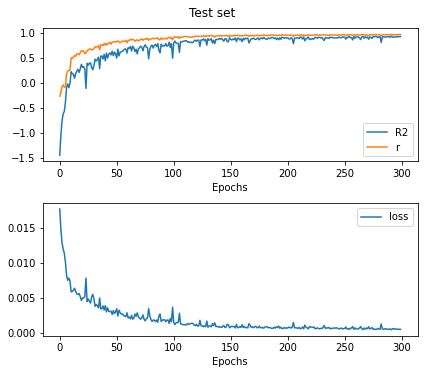

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,5),sharey=False)
x = np.arange(0,NUM_EPOCHS)
ax1.plot(x,np.array(r)[0],label="R2")
ax1.plot(x,np.array(r)[4],label="r")
ax2.plot(x,np.array(r)[1],label="loss")
ax1.set_xlabel("Epochs")
ax2.set_xlabel("Epochs")
ax1.legend()
ax2.legend()
f.tight_layout() 
f.suptitle("Test set",y=1.03)
plt.show()

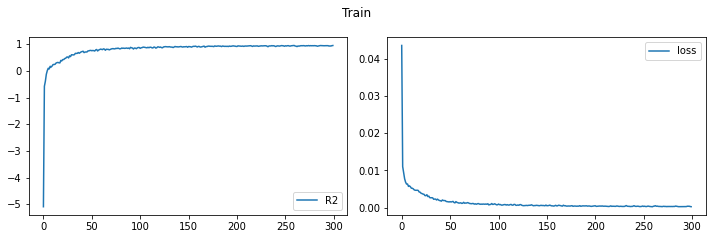

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3),sharey=False)
x = np.arange(0,NUM_EPOCHS)
ax1.plot(x,np.array(r)[2],label="R2")
ax2.plot(x,np.array(r)[3],label="loss")
ax1.legend()
ax2.legend()
f.tight_layout() 
f.suptitle("Train",y=1.09)
plt.show()

TUNING HYPER PARAMETERS

In [ ]:
learning_rate=[0.001,0.0001]
#batch_size=[90,150,200,250]
batch_size = [32,64,128,200,250]
parameters = [learning_rate,batch_size]
dataset_train = [np.array(X_train),np.array(y_train)]
dataset_test = [np.array(X_test),np.array(y_test)]
results=hypertuning_NN(dataset_train,dataset_test,parameters,NUM_EPOCHS,2)

PARAMETERS: LEARNING RATE = 0.001, BATCH_SIZE = 32
Starting training
	Epoch 0   | R2 score: -1.8480777639113486, r score: -0.026655616201573792
	Epoch 50   | R2 score: 0.514948870629534, r score: 0.82163545604103
	Epoch 100   | R2 score: 0.7867416403379689, r score: 0.9109352180729978
	Epoch 150   | R2 score: 0.7128744799346713, r score: 0.9104475196364448
	Epoch 200   | R2 score: 0.8606263205211532, r score: 0.9391573147881932
	Epoch 250   | R2 score: 0.8580835908327685, r score: 0.9381191667567973
	Epoch 299   | R2 score: 0.8768490720982126, r score: 0.9449765409895733
PARAMETERS: LEARNING RATE = 0.001, BATCH_SIZE = 64
Starting training
	Epoch 0   | R2 score: -0.9503299043191165, r score: -0.09735929836911715
	Epoch 50   | R2 score: 0.6174842076724754, r score: 0.830788514659528
	Epoch 100   | R2 score: 0.7064457371938021, r score: 0.8825005853150585
	Epoch 150   | R2 score: 0.7975222465501995, r score: 0.9076625413392075
	Epoch 200   | R2 score: 0.868269662469928, r score: 0.9361426

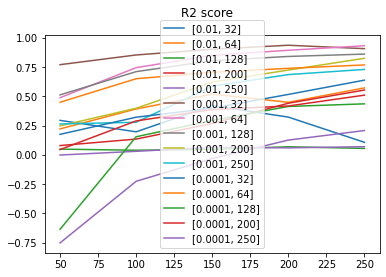

In [ ]:
plt.figure()
x = np.arange(50,NUM_EPOCHS,50)
param_combin = [[l_rate, b_size] for l_rate, b_size in product(*parameters)]
for i in range(len(param_combin)):
    plt.plot(x,np.array(results)[i][0][50::50],label=param_combin[i])
    #plt.legend(['{}'.format(i)])
plt.legend()
plt.suptitle("R2 score")
plt.show()

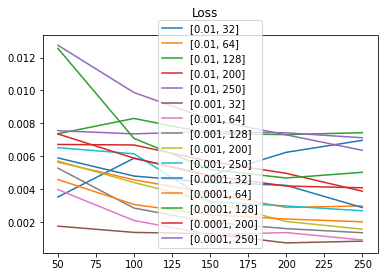

In [ ]:
plt.figure()
x = np.arange(50,NUM_EPOCHS,50)
param_combin = [[l_rate, b_size] for l_rate, b_size in product(*parameters)]
for i in range(len(param_combin)):
    plt.plot(x,np.array(results)[i][1][50::50],label=param_combin[i])
    #plt.legend(['{}'.format(i)])
plt.legend()
plt.suptitle("Loss")
plt.show()